Use CMIP6 2019.10a environment

# Set up workspace

In [23]:
import sys
import dask
import intake
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from distributed import Client

In [5]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    """Code from Daniel Kennedy"""
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='UWAS0044', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [6]:
cluster, client = get_ClusterClient()
cluster.scale(20)

In [9]:
client

Client Scheduler: tcp://10.12.206.54:46861 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/czarakas/proxy/{port}/status,Cluster Workers: 20 Cores: 20 Memory: 500.00 GB


# Get data

In [4]:
cat = intake.open_esm_datastore(
    'glade-cesm2-le.json'
)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [77]:
subset = cat.search(component='lnd', 
                    frequency='month_1', 
                    variable='FPSN')

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/copy.py:282: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  y.__setstate__(state)


In [78]:
members = np.unique(subset.df.cesm_member_id)

In [79]:
len(members)

100

# Plot global mean temperature

In [80]:
ds=xr.open_mfdataset(subset.df[subset.df.cesm_member_id==members[0]].path.values, combine='by_coords')

In [85]:
landarea = (ds.area*ds.landfrac)[2,:,:]
landweights = landarea/landarea.sum(dim=['lat','lon'])

In [ ]:
atmweights = ds.gw[0,:]/(ds.gw[0,:].mean(dim='lat'))

0
1
2
3


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.12.206.39:44250'], ('where-047ed85238ddcce19a14dfeeb5c1d33f', 17, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.12.206.39:44422'], ('where-047ed85238ddcce19a14dfeeb5c1d33f', 21, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.12.206.39:44422'], ('where-047ed85238ddcce19a14dfeeb5c1d33f', 18, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.12.206.39:44250'], ('where-047ed85238ddcce19a14dfeeb5c1d33f', 20, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.12.206.39:39202'], ('where-047ed85238ddcce19a14dfeeb5c1d33f', 19, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.12.206.39:36289'], ('where-047ed85238ddcce19a14dfeeb5c1d33f', 0, 0, 0)
NoneType: None
distributed.scheduler -

Traceback (most recent call last):
  File "/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-116beca7bda4>", line 5, in <module>
    ds=xr.open_mfdataset(subset.df[subset.df.cesm_member_id==member].path.values, combine='by_coords')
  File "/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/backends/api.py", line 949, in open_mfdataset
    datasets, compat=compat, data_vars=data_vars, coords=coords, join=join
  File "/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/combine.py", line 696, in combine_by_coords
    join=join,
  File "/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/merge.py", line 782, in merge
    merge_result = merge_core(dict_like_objects, compat, join, fill_value=fill_value)
  File "/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/pytho

KeyboardInterrupt: 

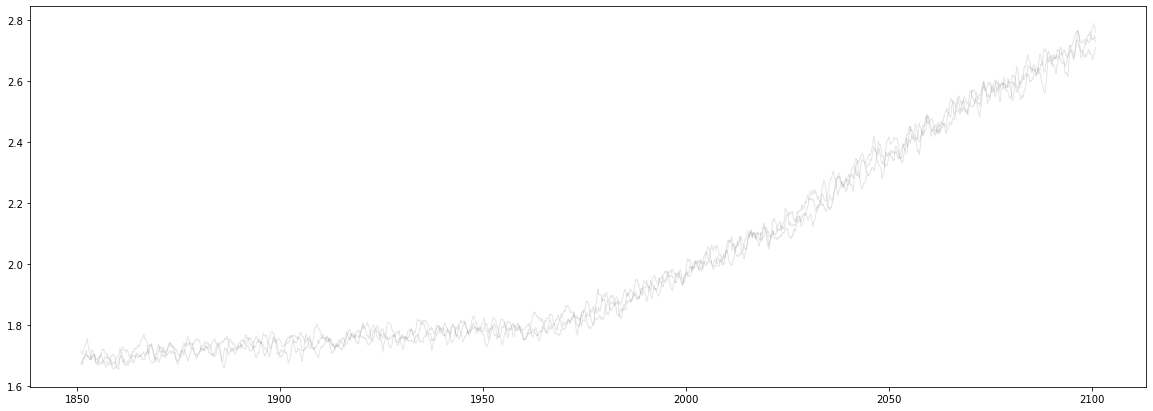

In [90]:
plt.figure(figsize=(20,7))
for i,member in enumerate(members):
    print(i)
    years=np.arange(0,3012)/12+1850 
    ds=xr.open_mfdataset(subset.df[subset.df.cesm_member_id==member].path.values, combine='by_coords')
    globalmean = (ds.FPSN*landweights).sum(dim=['lat','lon'])#(ds.TREFHT*atmweights).mean(dim=['lat','lon'])-273.15
    plt.plot(years,globalmean.rolling(time=12).mean(),
             '-k',linewidth=1, alpha=0.1)
plt.grid()

In [ ]:
#dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time': 5}})
#dsets#.keys()